# Statistics for Business - Salary Regression Model

- We need to import library and function that need to run the code in this notebook to:
  - load data
  - doing simulation
  - drawing graph and other visualization`

### Load Data

In [1]:
#Load Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec ##CEK UNTUK APA

# Modelling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Statistics 
import scipy.stats as stats

# cross validation using statsmodel prepartion
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, cross_validate, KFold

### Function

In [2]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :return df: <pandas DataFrame>  combined estimated coefficient and standard error of model estimate
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

## 1. Persiapan Data

In [3]:
df_salary = pd.read_csv("Salary_Data.csv")
df_salary.rename(columns={"Education Level" : "Education_level", "Years of Experience" : "Years_of_Experience"}, inplace = True)
df_salary

,Age,Gender,Education_level,Job Title,Years_of_Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0
371,43.0,Male,Master's,Director of Operations,19.0,170000.0
372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0
373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0


In [4]:
df_salary.shape

(375, 6)

### 1.1 Handling Missing Value

In [5]:
df_salary.isna().sum()

Age                    2
Gender                 2
Education_level        2
Job Title              2
Years_of_Experience    2
Salary                 2
dtype: int64

In [6]:
df_salary[df_salary["Years_of_Experience"].isna()]

,Age,Gender,Education_level,Job Title,Years_of_Experience,Salary
172,NaN,NaN,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN,NaN,NaN


**Menghapus missing value**

In [7]:
df_salary = df_salary.dropna()

In [8]:
df_salary.isna().sum()

Age                    0
Gender                 0
Education_level        0
Job Title              0
Years_of_Experience    0
Salary                 0
dtype: int64

### 1.2 Handling Duplicated Data

In [9]:
df_salary.duplicated().sum()

49

In [10]:
df_salary[df_salary.duplicated(keep=False)]

,Age,Gender,Education_level,Job Title,Years_of_Experience,Salary
140,28.0,Male,Bachelor's,Junior Business Analyst,2.0,40000.0
195,28.0,Male,Bachelor's,Junior Business Analyst,2.0,40000.0
209,30.0,Female,Bachelor's,Junior Marketing Coordinator,2.0,40000.0
210,38.0,Male,Master's,Senior IT Consultant,9.0,110000.0
211,45.0,Female,PhD,Senior Product Designer,15.0,150000.0
...,...,...,...,...,...,...
369,33.0,Male,Bachelor's,Junior Business Analyst,4.0,60000.0
370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0
372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0
373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0


**Menghapus duplicated data**

In [11]:
df_salary = df_salary.drop_duplicates(keep="first")
df_salary.duplicated().sum()

0

In [12]:
df_salary.shape

(324, 6)

In [13]:
df_salary

,Age,Gender,Education_level,Job Title,Years_of_Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
348,28.0,Female,Bachelor's,Junior Operations Manager,1.0,35000.0
349,36.0,Male,Bachelor's,Senior Business Development Manager,8.0,110000.0
350,44.0,Female,PhD,Senior Data Scientist,16.0,160000.0
351,31.0,Male,Bachelor's,Junior Marketing Coordinator,3.0,55000.0


## 2. Deskripsi Statistik Data

In [14]:
df_salary.describe()

,Age,Years_of_Experience,Salary
count,324.000000,324.000000,324.000000
mean,37.382716,10.058642,99985.648148
std,7.185844,6.650470,48652.271440
min,23.000000,0.000000,350.000000
25%,31.000000,4.000000,55000.000000
50%,36.500000,9.000000,95000.000000
75%,44.000000,16.000000,140000.000000
max,53.000000,25.000000,250000.000000


In [15]:
df_salary["Gender"].value_counts()

Gender
Male      170
Female    154
Name: count, dtype: int64

In [16]:
df_salary["Education_level"].value_counts()

Education_level
Bachelor's    191
Master's       91
PhD            42
Name: count, dtype: int64

In [17]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, 0 to 371
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  324 non-null    float64
 1   Gender               324 non-null    object 
 2   Education_level      324 non-null    object 
 3   Job Title            324 non-null    object 
 4   Years_of_Experience  324 non-null    float64
 5   Salary               324 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB


### 2.1 Correlation in Numerical Variable

In [18]:
df_salary[["Age", "Years_of_Experience", "Salary"]].corr()

,Age,Years_of_Experience,Salary
Age,1.000000,0.979192,0.916543
Years_of_Experience,0.979192,1.000000,0.924455
Salary,0.916543,0.924455,1.000000


Korelasi antara Age, Years_of_Experience, dan Salary memiliki hasil positive dan berkorelasi kuat

### 2.2 Average Salary in each Categorical Variable

**Perbandingan Salary based on Gender**

In [19]:
df_salary.groupby("Gender")["Salary"].mean()

Gender
Female     96136.363636
Male      103472.647059
Name: Salary, dtype: float64

Rata-rata gaji laki-laki lebih tinggi dari rata-rata gaji perempuan

**Perbandingan Salary based on Education Level**

In [20]:
df_salary.groupby("Education_level")["Salary"].mean()

Education_level
Bachelor's     73902.356021
Master's      127912.087912
PhD           158095.238095
Name: Salary, dtype: float64

Orang yang memiliki pendidikan yang semakin tinggi memiliki rata-rata gaji yang lebih tinggi.

### 2.3. Numerical Variables with each Categorical Variables

**Numerical Variable with Gender**

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


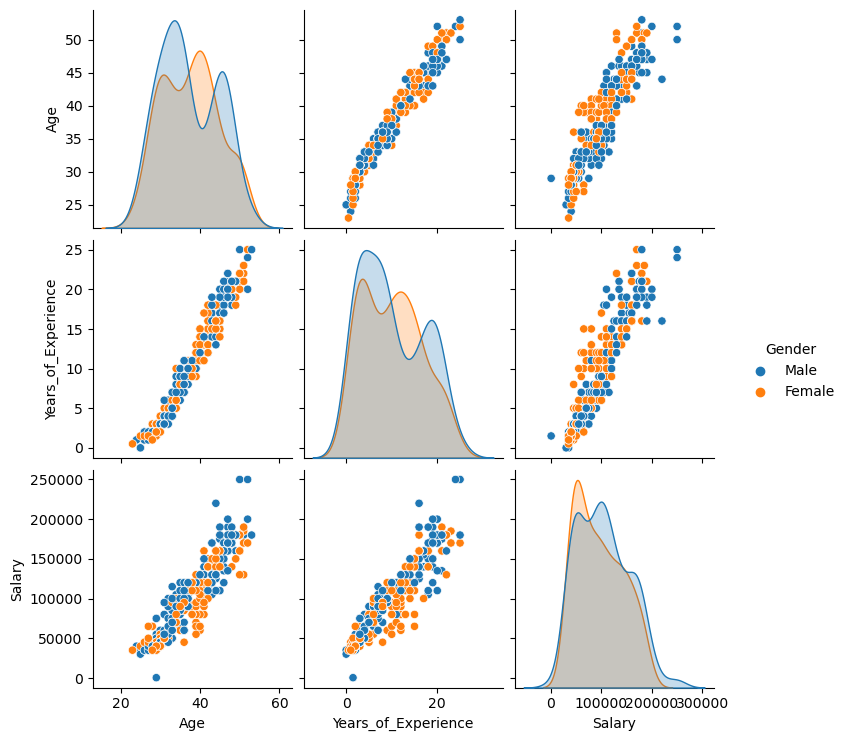

In [21]:
sns.pairplot(data= df_salary, hue = "Gender", height=2.5)

- Semakin bertambah usia seseorang, gaji yang didapat juga semakin tinggi
- Semakin lama pengalaman kerja seseorang, gaji yang didapat juga semakin tinggi
- Variabel jenis kelamin tidak memberikan pola apapun pada setiap variabel numerik terhadap gaji


**Numerical Variable with Education Level**

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


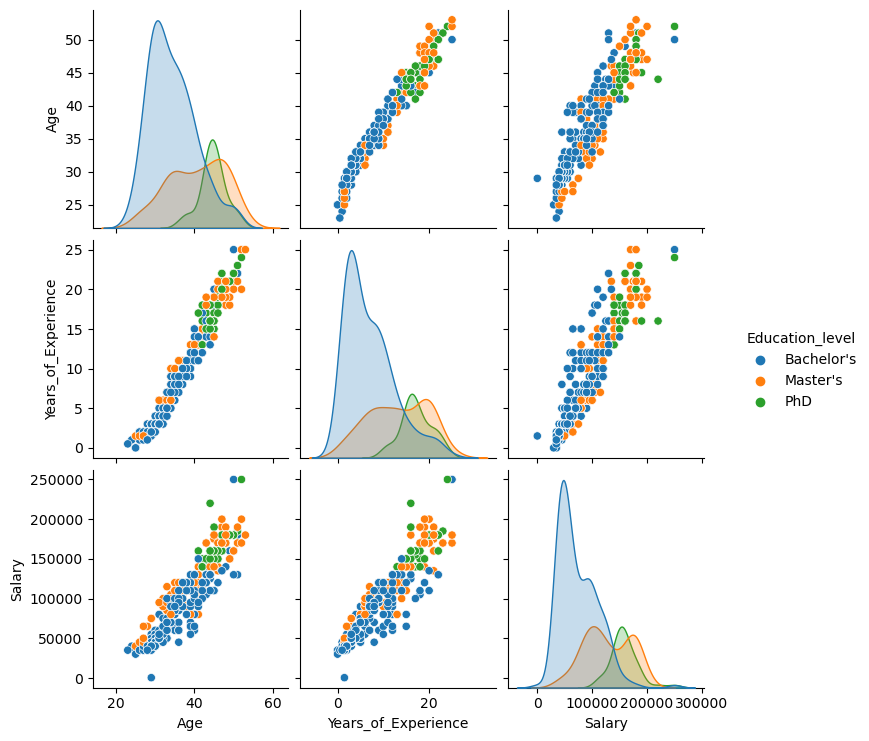

In [22]:
sns.pairplot(data = df_salary, hue = "Education_level", height=2.5)

- Kenaikan tingkat pendidikan berhubungan positif dengan peningkatan besaran gaji seseorang.
- Seseorang yang lebih tua cenderung memiliki tingkat pendidikan yang lebih tinggi.
- Orang dengan tingkat pendidikan tinggi juga cenderung memiliki pengalaman kerja yang lebih lama.

## 3. Uji Statistik

$H_0$: Rata-rata gaji laki-laki sama dengan dari rata-rata gaji perempuan.
$$ H_0:\mu_A = \mu_B $$

$H_1$: Rata-rata gaji laki-laki lebih besar dari rata-rata gaji perempuan.
$$ H_1:\mu_A > \mu_B $$

In [23]:
significance_level = 0.05

In [24]:
# Menghitung jumlah rat-rata gaji laki-laki dan perempuan
df_salary.groupby("Gender")["Salary"].mean()

Gender
Female     96136.363636
Male      103472.647059
Name: Salary, dtype: float64

**Rata-rata gaji laki-laki lebih tinggi dari rata-rata gaji perempuan**



Karena standar deviasi populasi tidak diketahui, maka t-test akan digunakan untuk pengujian.

In [25]:
#Salary Laki-laki
df_male = df_salary[df_salary["Gender"]=="Male"]["Salary"].values

#Salary Perempuan
df_female = df_salary[df_salary["Gender"]=="Female"]["Salary"].values

#Varianse
np.var(df_male), np.var(df_female)

(2571353207.6989617, 2097896989.374262)

- Dari hasil diatas menunjukkan bahwa varians tidak sama

In [26]:
result = stats.ttest_ind(a = df_male,
                         b = df_female,
                         equal_var = False,
                         alternative = "greater")

In [27]:
# Menentukan p-value
result.pvalue

0.08675461782037655

In [28]:
result.statistic

1.364034982496829

In [29]:
# menetukan aturan keputusan
if result.pvalue < significance_level:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the Null hypothesis")

Failed to reject the Null hypothesis


**Terdapat cukup bukti bahwa rata-rata gaji laki-laki dan perempuan tidak sama. Rata-rata gaji laki-laki lebih tinggi dari perempuan**

**Degree of freedom**

In [30]:
df_data = len(df_male)+len(df_female)-2
df_data

322

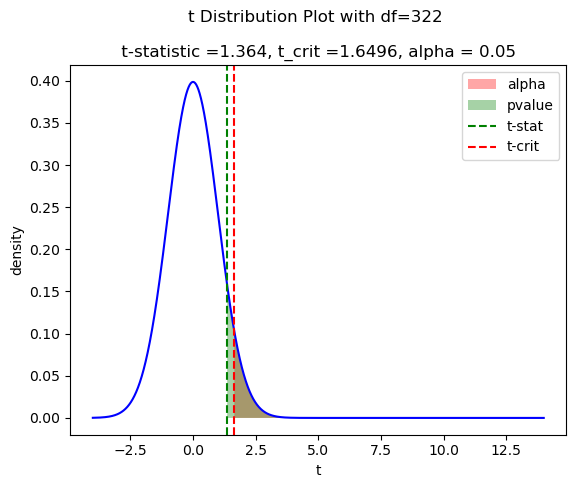

In [31]:
#plot sample distriibution
x = np.arange(-4,14, 0.001)
plt.plot(x,stats.t.pdf(x, df= df_data), color='blue')

#plot aplha region
x_alpha = np.arange(stats.t.ppf(1-significance_level, df = df_data), 4, 0.01)
y_alpha = stats.t.pdf(x_alpha, df = df_data)
plt.fill_between(x = x_alpha, y1 = y_alpha, facecolor = 'red', alpha= 0.35, label ='alpha')

#plot pvalue
x_pvalue = np.arange(result.statistic, 4, 0.01)
y_pvalue = stats.t.pdf(x_pvalue, df=df_data)
plt.fill_between(x = x_pvalue, y1= y_pvalue, facecolor = 'green', alpha = 0.35, label='pvalue')

#plot t-crit and t-stats
plt.axvline(np.round(result.statistic,4), color='green', linestyle = '--', label='t-stat')

t_crit = np.round(stats.t.ppf(1-significance_level,df = df_data),4)
plt.axvline(t_crit, color='red', linestyle = '--', label='t-crit')

plt.legend()
plt.xlabel("t")
plt.ylabel("density")

plt.title(f't Distribution Plot with df={df_data} \n\n t-statistic ={np.round(result.statistic, 4)}, t_crit ={np.round(t_crit, 4)}, alpha = {significance_level} ');
          

**Confidence Level**

In [32]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

cm = CompareMeans(d1 = DescrStatsW(data=df_male), 
                  d2 = DescrStatsW(data=df_female))

lower, upper = cm.tconfint_diff(alpha=significance_level, 
                                alternative='two-sided', 
                                usevar='unequal')

print("Confidence Interval", ":", "[", lower, upper, "]")

Confidence Interval : [ -3244.897152030464 17917.463996950246 ]


- Dapat disimpulkan bahwa dengan tingkat kepercayaan 95%, penguji yakin bahwa rata-rata gaji laki-laki lebih dari rata-rata gaji perempuan. 
- Dengan tingkat kepercayaan 95%, rata-rata perbedaan gaji memiliki interval di -3245 samapi dengan 17917

## 4. Model Regresi

In [36]:
# Mengahapus kolom Job Titte
df_salary.drop("Job Title", axis=1, inplace=True)

In [37]:
df_salary.head()

,Age,Gender,Education_level,Years_of_Experience,Salary
0,32.0,Male,Bachelor's,5.0,90000.0
1,28.0,Female,Master's,3.0,65000.0
2,45.0,Male,PhD,15.0,150000.0
3,36.0,Female,Bachelor's,7.0,60000.0
4,52.0,Male,Master's,20.0,200000.0


**Mengubah data kategori menjadi data numeric**

In [38]:
# Use LabelEncoder to convert the smoker variable into numeric
from sklearn.preprocessing import LabelEncoder

# Mapping
gender_mapping = {"Male": 0, "Female": 1}
edu_mapping = {"Bachelor's":0 , "Master's":1 , "PhD":2}

# Create LabelEncoder Object and Transform the Age and education variable
df_salary["Gender"] = LabelEncoder().fit_transform(df_salary["Gender"].map(gender_mapping))
df_salary["Education_level"] = LabelEncoder().fit_transform(df_salary["Education_level"].map(edu_mapping))

# Display the 5th first row after transforming
df_salary.head()

,Age,Gender,Education_level,Years_of_Experience,Salary
0,32.0,0,0,5.0,90000.0
1,28.0,1,1,3.0,65000.0
2,45.0,0,2,15.0,150000.0
3,36.0,1,0,7.0,60000.0
4,52.0,0,1,20.0,200000.0


## 4.1 Model Regresi 1 Prediktor

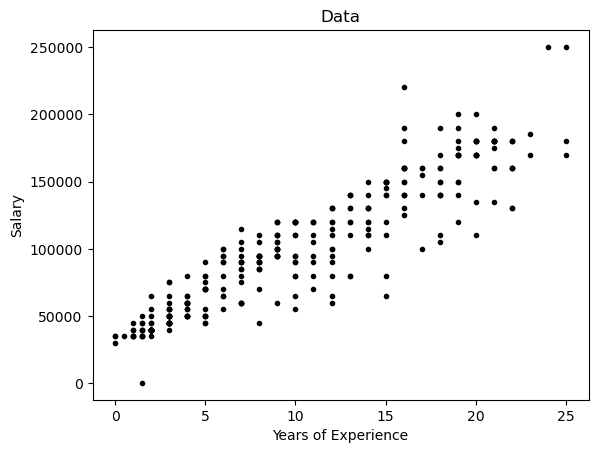

In [39]:
#Melihat hubungan antara pengalaman kerja dan gaji
x = df_salary["Years_of_Experience"]
y = df_salary["Salary"]

#Plot the data
plt.scatter(x,y, color="k", marker=".")

#Add a legend and labels
plt.xlabel("Years of Experience")
plt.ylabel("Salary")

#Add a title
plt.title("Data")

#Show the plot
plt.show()

Dari grafik di atas, pengalaman kerja dan gaji menunjukkan hubungan positif. Semakin lama pengalaman kerja, variasi gaji yang didapatkan cenderung lebih besar

### 4.1.1. Fit Linear Regression 

In [40]:
#Create OLS model object
model = smf.ols("Salary ~ Years_of_Experience", df_salary)

#Fit the model
results_model_salary = model.fit()

#Extract the results (Coefficient and Standard Error) to Dataframe
results_salary = print_coef_std_err(results_model_salary)
results_salary

,coef,std err
Intercept,31959.508721,1873.552736
Years_of_Experience,6762.954641,155.446221


In [104]:
results_model_salary.rsquared

0.854616668146078

$$\text{Salary} = 31960 + 6763\times\text{Years of Experience}$$

- Dengan membandingakan dua orang yang memiliki perbedaan 1 tahun di pengalaman kerja, diperkirakan orang yang memiliki pengalaman kerja lebih lama memiliki selisih 6763 lebih besar.
- Untuk orang yang memiliki 0 tahun pengalaman kerja, memiliki perkiraan rata-rata gaji sebesar 31,960

**Visualisasi**


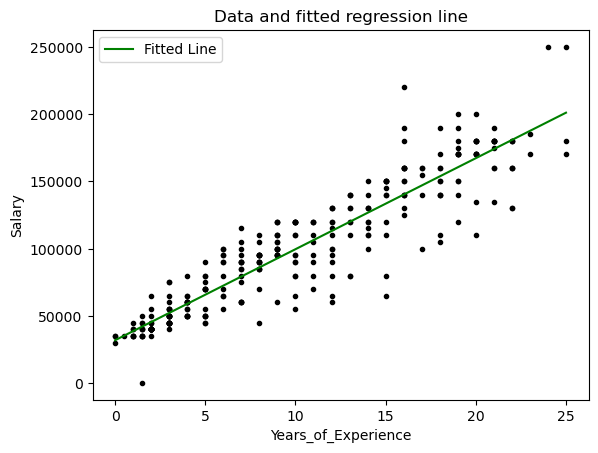

In [41]:
predictor = "Years_of_Experience"
outcome ="Salary"
data = df_salary.copy()
results_ = results_salary.copy()

#Plot the data
plt.scatter(data[predictor],data[outcome], color ="k", marker =".")

#Calcultae the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]),10000)

fitted_values = a_hat + b_hat * x_domain

#Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted Line", color="g")

#Add a legend and Label
plt.legend()
plt.xlabel(predictor)
plt.ylabel(outcome)

#Add a title 
plt.title("Data and fitted regression line")
plt.show()

**Residual Plot**

Text(0.5, 1.0, 'Residual Plot vs. Predicted Value')

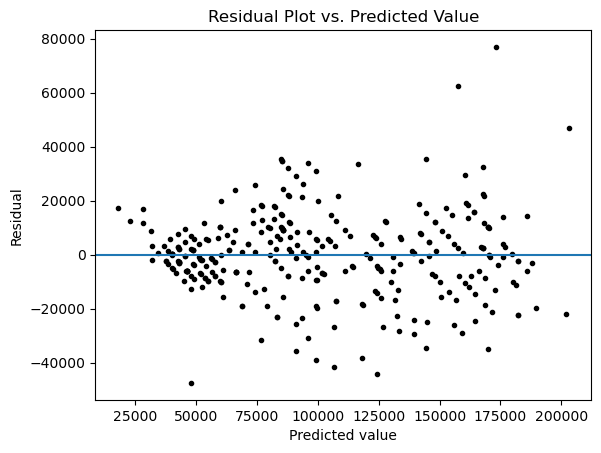

In [65]:
#Residual Plot and Explained Variance
plt.scatter(results_model_salary.fittedvalues, results_model_salary.resid, marker=".", color="k")

#Plot thehorizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("Predicted value")
plt.ylabel("Residual")
plt.title("Residual Plot vs. Predicted Value")

In [43]:
results_model_salary.rsquared

0.854616668146078

Residual plot menghasilkan pola yang terlihat jelas, hal ini membuat ketidaksesuaian terlihat meskipun garis regresi  menjelaskan lebih dari 85% variansi lama pengalaman kerja

#### Normality of error assumption 

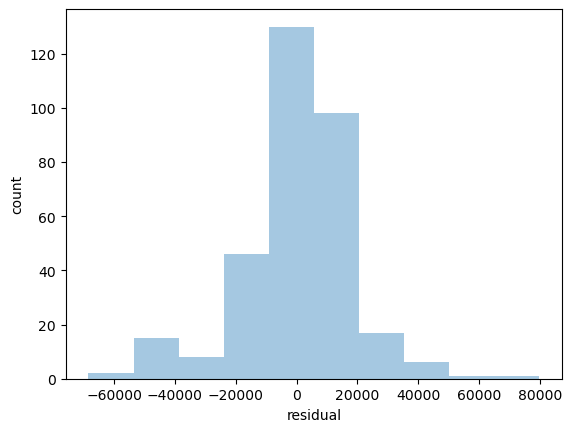

In [44]:
plt.hist(results_model_salary.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

### 4.1.2. Fit Linear Regression - Using Log Transform on Weight Variable

In [45]:
df_salary["logYoE"] = np.log(df_salary["Years_of_Experience"])
df_salary.loc[df_salary["Years_of_Experience"]==0, "logYoE"] = 0
df_salary

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Age,Gender,Education_level,Years_of_Experience,Salary,logYoE
0,32.0,0,0,5.0,90000.0,1.609438
1,28.0,1,1,3.0,65000.0,1.098612
2,45.0,0,2,15.0,150000.0,2.708050
3,36.0,1,0,7.0,60000.0,1.945910
4,52.0,0,1,20.0,200000.0,2.995732
...,...,...,...,...,...,...
348,28.0,1,0,1.0,35000.0,0.000000
349,36.0,0,0,8.0,110000.0,2.079442
350,44.0,1,2,16.0,160000.0,2.772589
351,31.0,0,0,3.0,55000.0,1.098612


In [46]:
df_salary.describe()

,Age,Gender,Education_level,Years_of_Experience,Salary,logYoE
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,37.382716,0.475309,0.540123,10.058642,99985.648148,2.005576
std,7.185844,0.500162,0.713597,6.650470,48652.271440,0.874208
min,23.000000,0.000000,0.000000,0.000000,350.000000,-0.693147
25%,31.000000,0.000000,0.000000,4.000000,55000.000000,1.386294
50%,36.500000,0.000000,0.000000,9.000000,95000.000000,2.197225
75%,44.000000,1.000000,1.000000,16.000000,140000.000000,2.772589
max,53.000000,1.000000,2.000000,25.000000,250000.000000,3.218876


In [47]:
#Create OLS model object
model = smf.ols("Salary ~ logYoE", df_salary)

#FIt the model
results_logtransform = model.fit()

#Extract the results (Coefficeint and Standard Error) to Dataframe
results_salary_log = print_coef_std_err(results_logtransform)
results_salary_log

,coef,std err
Intercept,2321.447994,3284.146736
logYoE,48696.340871,1501.472036


In [48]:
results_logtransform.rsquared

0.7656239539695424

Nilai R squared pada regresi linier dengan transformasi log lebih kecil daripada nilai R Squared tanpa transformasi. Maka performance model regresi tanpa transformasi lebih baik

## 4.2. Multiple Predictors Modelling

**Data Preparation**

In [49]:
df_salary.drop("logYoE", axis=1, inplace=True)
df_salary

,Age,Gender,Education_level,Years_of_Experience,Salary
0,32.0,0,0,5.0,90000.0
1,28.0,1,1,3.0,65000.0
2,45.0,0,2,15.0,150000.0
3,36.0,1,0,7.0,60000.0
4,52.0,0,1,20.0,200000.0
...,...,...,...,...,...
348,28.0,1,0,1.0,35000.0
349,36.0,0,0,8.0,110000.0
350,44.0,1,2,16.0,160000.0
351,31.0,0,0,3.0,55000.0


In [50]:
class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param data: <pandas DataFrame> 
    :param n_fold: <int> Number of fold in k-fold CV
    :return fold_train: <pandas DataFrame> Training Data
    :return fold_test: <pandas DataFrame> Testing Data
    """
    kfold = KFold(n_splits = n_fold, 
                  shuffle = True, 
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
        
    return (fold_train, fold_test)

### Evaluate a model using K-fold cross validation

In [51]:
# Create a class model
ols_all_pred = StatsmodelsRegressor(smf.ols, "Salary ~ Age + Gender + C(Education_level) + Years_of_Experience + Age:Years_of_Experience")

In [52]:
#Data Splitting Results
fold_train, fold_test = kfold_split(data = df_salary, n_fold=5)

fold 1, train data rows: 259, test data rows: 65
fold 2, train data rows: 259, test data rows: 65
fold 3, train data rows: 259, test data rows: 65
fold 4, train data rows: 259, test data rows: 65
fold 5, train data rows: 260, test data rows: 64


In [53]:
fold_train[0]

,Age,Gender,Education_level,Years_of_Experience,Salary
0,32.0,0,0,5.0,90000.0
1,28.0,1,1,3.0,65000.0
2,45.0,0,2,15.0,150000.0
3,36.0,1,0,7.0,60000.0
4,52.0,0,1,20.0,200000.0
...,...,...,...,...,...
348,28.0,1,0,1.0,35000.0
349,36.0,0,0,8.0,110000.0
350,44.0,1,2,16.0,160000.0
351,31.0,0,0,3.0,55000.0


In [54]:
fold_test[0]

,Age,Gender,Education_level,Years_of_Experience,Salary
11,48.0,1,0,18.0,140000.0
12,35.0,0,0,6.0,65000.0
19,51.0,0,0,22.0,180000.0
20,34.0,1,1,5.0,80000.0
26,37.0,1,1,11.0,110000.0
...,...,...,...,...,...
327,32.0,0,0,3.0,55000.0
333,33.0,0,0,4.0,60000.0
339,33.0,0,0,5.0,70000.0
341,43.0,0,1,18.0,170000.0


In [55]:
# Create k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

scores_ols_all_pred = cross_val_score(estimator = ols_all_pred,
                                       X = df_salary,
                                       y = df_salary["Salary"],
                                       cv = kfold,
                                       scoring = "r2")

scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, 
                                    columns=["test_rsquared"])

scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.892141,Folds 1
1,0.902729,Folds 2
2,0.912515,Folds 3
3,0.825113,Folds 4
4,0.897267,Folds 5


In [56]:
scores_ols_all_pred["test_rsquared"].mean()

0.8859529642576712

Model yang menggunakan semua media memiliki kecocokan yang baik, model ini dapat menjelaskan 88,59% varians gaji. Mari kita bangun model dengan menggunakan seluruh data untuk menyimpulkan estimasi koefisien dari model, dan mendapatkan wawasan dari prespektif bisnis

## Fit Linear Regression - Using All Predictors

In [59]:
# Create OLS model object
model = smf.ols("Salary ~ Age + Gender + C(Education_level) + Years_of_Experience + Age:Years_of_Experience", df_salary)

# Fit the model
results_model_salary = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_salary = print_coef_std_err(results_model_salary)
results_salary

,coef,std err
Intercept,-44159.185552,16580.736611
C(Education_level)[T.1],19574.074815,2257.344892
C(Education_level)[T.2],26339.473807,3160.610738
Age,3042.039143,611.919060
Gender,-9310.571777,1766.475849
Years_of_Experience,2433.641886,1211.995905
Age:Years_of_Experience,3.452762,21.044653


Nilai intercept negatif sehingga kurang bermakna.

### Melakukan Centering Predictor Age

Centering dilakukan agar interpretasi hasil regresi lebih baik

In [60]:
mean_age = df_salary["Age"].mean()
mean_age = np.round(mean_age,0)
mean_age

37.0

In [61]:
df_salary["Age"] = df_salary["Age"]-mean_age
df_salary.rename(columns = {"Age":"Age_Centered"}, inplace=True)
df_salary.head()

,Age_Centered,Gender,Education_level,Years_of_Experience,Salary
0,-5.0,0,0,5.0,90000.0
1,-9.0,1,1,3.0,65000.0
2,8.0,0,2,15.0,150000.0
3,-1.0,1,0,7.0,60000.0
4,15.0,0,1,20.0,200000.0


In [62]:
# Create a class model
ols_all_pred = StatsmodelsRegressor(smf.ols, "Salary ~ Age_Centered + Gender + C(Education_level) + Years_of_Experience + Age_Centered:Years_of_Experience")

# Create k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=12)

scores_ols_all_pred = cross_val_score(estimator = ols_all_pred,
                                       X = df_salary,
                                       y = df_salary["Salary"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, 
                                    columns=["test_rsquared"])
scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.849681,Folds 1
1,0.907836,Folds 2
2,0.873470,Folds 3
3,0.938117,Folds 4
4,0.881399,Folds 5


In [63]:
scores_ols_all_pred["test_rsquared"].mean()

0.8901007028969223

Model yang menggunakan semua media memiliki kecocokan yang baik, model ini dapat menjelaskan 89% varians gaji. Mari kita bangun model dengan menggunakan seluruh data untuk menyimpulkan estimasi koefisien dari model, dan mendapatkan wawasan dari prespektif bisnis

In [64]:
# Create OLS model object
model = smf.ols('Salary ~ Age_Centered + Gender + C(Education_level) + Years_of_Experience + Age_Centered:Years_of_Experience', df_salary)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_salary = print_coef_std_err(results)
results_salary

,coef,std err
Intercept,68396.262743,6722.803498
C(Education_level)[T.1],19574.074815,2257.344892
C(Education_level)[T.2],26339.473807,3160.610738
Age_Centered,3042.039143,611.919060
Gender,-9310.571777,1766.475849
Years_of_Experience,2561.394070,714.405923
Age_Centered:Years_of_Experience,3.452762,21.044653


$$\text{Salary for Bachelor's} = 68396 + 3042\times\text{(Age - 37)} - 9311\times\text{Gender} + 2561\times\text{Years_of_Experience} + 3\times\text{(Age - 37)}\times\text{Years_of_Experience} $$

$$\text{Salary for Master's} = 68396+ 19574 + 3042\times\text{(Age - 37)} - 9311\times\text{Gender} + 2561\times\text{Years_of_Experience} + 3\times\text{(Age - 37)}\times\text{Years_of_Experience} $$

$$\text{Salary for PhD} = 68396 + 26339 + 3042\times\text{(Age - 37)} - 9311\times\text{Gender} + 2561\times\text{Years_of_Experience} + 3\times\text{(Age - 37)}\times\text{Years_of_Experience} $$

**Interpretasi tingkat pendidikan**

Jika mengamati dua individu dengan usia, jenis kelamin, dan lama pengalaman kerja yang identik, perkiraan gaji seseorang yang memiliki gelar Master's diperkirakan lebih tinggi sebesar 19574 dolar dibandingkan dengan individu yang memiliki gelar Bachelor's.

Kemudian jika mengamati dua individu dengan usia, jenis kelamin, dan lama pengalaman kerja yang identik, perkiraan gaji seseorang yang memiliki gelar PhD diperkirakan lebih tinggi sebesar 26339 dolar dibandingkan dengan individu yang memiliki gelar Bachelor's.

**Interpretasi usia**

Jika mengamati dua individu dengan jenis kelamin dan tingkat pendidikan yang sama, dengan lama pengalaman kerja = 0, perkiraan gaji seseorang yang memiliki usia lebih 1 tahun dari 37 tahun,  diperkirakan lebih tinggi sebesar 3042 dolar dibandingkan dengan individu yang memiliki usia 37 tahun

**Interpretasi jenis kelamin**

Jika mengamati dua individu yang memiliki usia, lama pengalaman kerja, dan tingkat pendidikan yang sama, perkiraan gaji seorang perempuan lebih sedikit 9311 dollar dibandingkan dengan seorang laki-laki.

**Interpretasi lama pengalaman kerja**

jika mengamati dua individu dengan usia = 37 tahun, jenis kelamin, dan tingkat pendidikan yang identik, perkiraan gaji seseorang yang memiliki pengalaman kerja lebih lama 1 tahun diperkirakan lebih tinggi sebesar 2561 dolar.

Text(0.5, 1.0, 'Residuals vs. Predicted value')

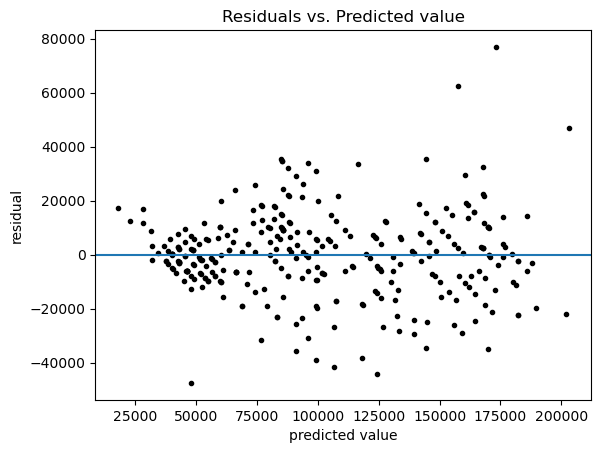

In [67]:
# Residual Plot and Explained Variance
plt.scatter(results.fittedvalues, results.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted value")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted value")

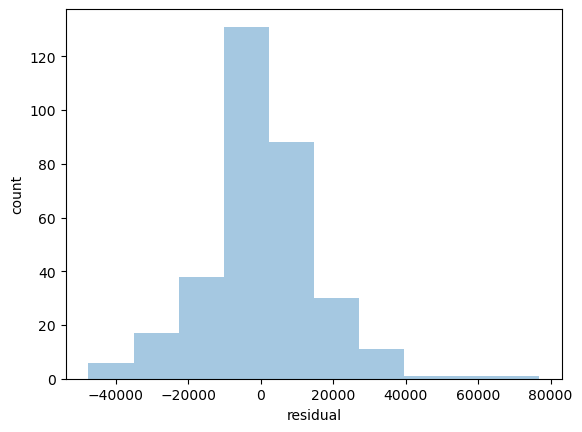

In [68]:
# Normality of Error Assumption

plt.hist(results.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()